# EGCI 425 - Step 3: Attribute Selection

**Objectives:**
1. Apply 3 different attribute selection methods
2. Compare selected features from each method
3. Identify most important features for classification

**Three Methods:**
1. **Correlation-based Feature Selection** - Statistical relationship with target
2. **Recursive Feature Elimination (RFE)** - Iterative feature removal
3. **Tree-based Feature Importance** - Random Forest importance scores

**Dataset:** 231 movies, 12 features (after preprocessing)

---
## 1. Import Libraries and Load Data

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Feature selection methods
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Model evaluation
from sklearn.model_selection import cross_val_score

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

✓ Libraries imported successfully!


In [2]:
# Load preprocessed data
file_path = 'dataset/step2_preprocessed_data.csv'

df = pd.read_csv(file_path)

print(f"✓ Dataset loaded successfully!")
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print("\nFirst few rows:")
df.head()

✓ Dataset loaded successfully!
Shape: 231 rows × 14 columns

First few rows:


,Movie,Year,Ratings,Genre,Gross,Budget,Screens,Sequel,Sentiment,Views,Likes,Dislikes,Comments,Aggregate Followers
0,13 Sins,2014,6.3000,8,9130,4000000.0000,45.0000,1,0,3280543.0000,4632.0000,425,636.0000,1120000.0000
1,22 Jump Street,2014,7.1000,1,192000000,50000000.0000,3306.0000,2,2,583289.0000,3465.0000,61,186.0000,12350000.0000
2,3 Days to Kill,2014,6.2000,1,30700000,28000000.0000,2872.0000,1,0,304861.0000,328.0000,34,47.0000,483000.0000
3,300: Rise of an Empire,2014,6.3000,1,106000000,110000000.0000,3470.0000,2,0,452917.0000,2429.0000,132,590.0000,568000.0000
4,A Haunted House 2,2014,4.7000,8,17300000,3500000.0000,2310.0000,2,0,3145573.0000,12163.0000,610,1082.0000,1923800.0000


---
## 2. Prepare Data for Attribute Selection

In [4]:
print("DATA PREPARATION\n")

# Separate features and target
feature_cols = [col for col in df.columns if col not in ['Movie', 'Ratings']]
target_col = 'Ratings'

X = df[feature_cols]
y = df[target_col]

print(f"\nFeatures (X): {X.shape}")
print(f"  Columns: {list(X.columns)}")
print(f"\nTarget (y): {y.shape}")
print(f"  Variable: {target_col}")
print(f"  Range: [{y.min():.1f}, {y.max():.1f}]")
print(f"  Mean: {y.mean():.2f}")

print(f"\nData Quality Check:")
print(f"  Missing values in X: {X.isnull().sum().sum()}")
print(f"  Missing values in y: {y.isnull().sum()}")

if X.isnull().sum().sum() == 0 and y.isnull().sum() == 0:
    print("\nData is clean")
else:
    print("\nMissing values detected!")

DATA PREPARATION


Features (X): (231, 12)
  Columns: ['Year', 'Genre', 'Gross', 'Budget', 'Screens', 'Sequel', 'Sentiment', 'Views', 'Likes', 'Dislikes', 'Comments', 'Aggregate Followers']

Target (y): (231,)
  Variable: Ratings
  Range: [3.1, 8.7]
  Mean: 6.44

Data Quality Check:
  Missing values in X: 0
  Missing values in y: 0

Data is clean


---
## 3. Method 1: Correlation-Based Feature Selection

**Approach:** Select features with highest absolute correlation with target variable

In [5]:
print("METHOD 1: CORRELATION-BASED FEATURE SELECTION\n")

# Calculate Pearson correlation with target
correlations = X.corrwith(y).abs().sort_values(ascending=False)

print("\nAbsolute Correlation with Ratings:")
print("-" * 40)
for idx, (feature, corr) in enumerate(correlations.items(), 1):
    print(f"{idx:2d}. {feature:25s}: {corr:.4f}")

# Select top k features
k = 6
selected_features_corr = correlations.head(k).index.tolist()

print(f"\nSELECTED FEATURES (Top {k} by correlation):")
for idx, feature in enumerate(selected_features_corr, 1):
    print(f"{idx}. {feature} (corr: {correlations[feature]:.4f})")

# Store results
method1_results = {
    'method': 'Correlation-Based',
    'selected_features': selected_features_corr,
    'n_features': k,
    'scores': {feat: correlations[feat] for feat in selected_features_corr}
}

METHOD 1: CORRELATION-BASED FEATURE SELECTION


Absolute Correlation with Ratings:
----------------------------------------
 1. Gross                    : 0.3558
 2. Budget                   : 0.2855
 3. Dislikes                 : 0.1874
 4. Sentiment                : 0.1432
 5. Genre                    : 0.1167
 6. Sequel                   : 0.1057
 7. Likes                    : 0.0667
 8. Aggregate Followers      : 0.0615
 9. Screens                  : 0.0431
10. Views                    : 0.0260
11. Comments                 : 0.0136
12. Year                     : 0.0012

SELECTED FEATURES (Top 6 by correlation):
1. Gross (corr: 0.3558)
2. Budget (corr: 0.2855)
3. Dislikes (corr: 0.1874)
4. Sentiment (corr: 0.1432)
5. Genre (corr: 0.1167)
6. Sequel (corr: 0.1057)


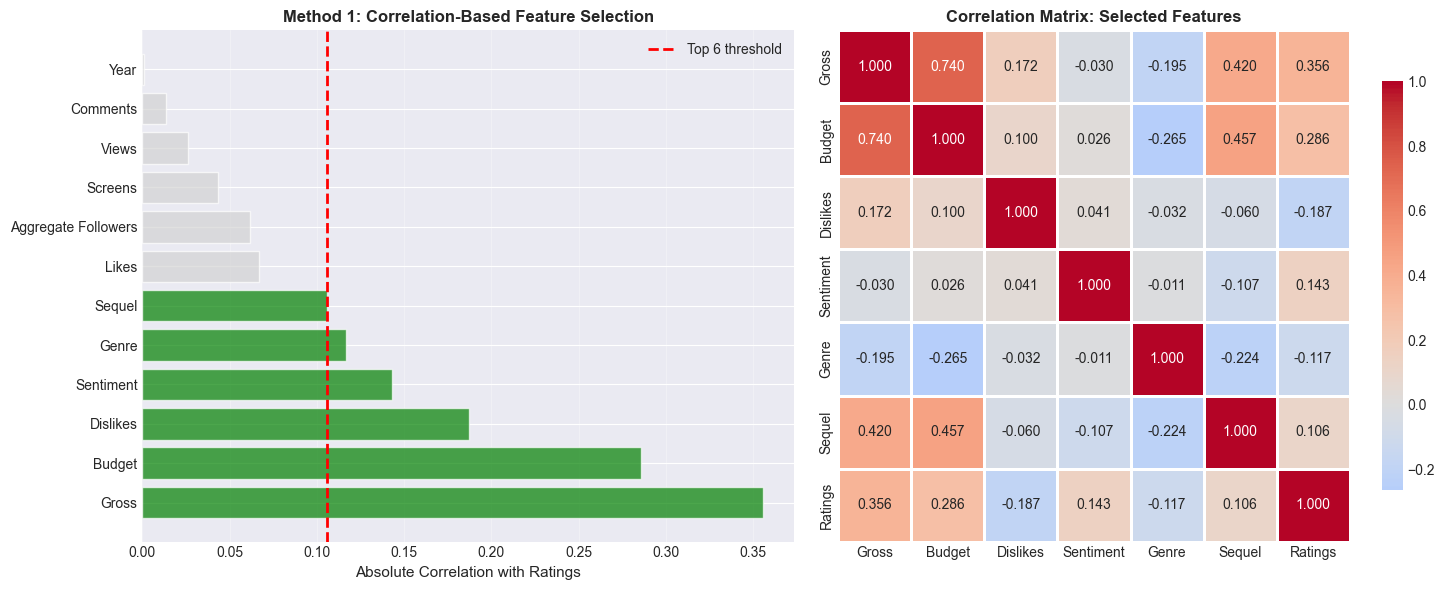


Top 6 features selected based on correlation


In [7]:
# Visualize correlations
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot of correlations
colors = ['green' if f in selected_features_corr else 'lightgray' for f in correlations.index]
axes[0].barh(correlations.index, correlations.values, color=colors, alpha=0.7)
axes[0].set_xlabel('Absolute Correlation with Ratings', fontsize=11)
axes[0].set_title('Method 1: Correlation-Based Feature Selection', fontsize=12, fontweight='bold')
axes[0].axvline(x=correlations.iloc[k-1], color='red', linestyle='--', linewidth=2, label=f'Top {k} threshold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='x')

# Heatmap of selected features
selected_data = df[selected_features_corr + ['Ratings']]
corr_matrix = selected_data.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=axes[1])
axes[1].set_title(f'Correlation Matrix: Selected Features', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nTop {k} features selected based on correlation")

---
## 4. Method 2: Recursive Feature Elimination (RFE)

**Approach:** Recursively removes features and builds model on remaining attributes

In [8]:
print("METHOD 2: RECURSIVE FEATURE ELIMINATION (RFE)\n")

# Use Random Forest as the estimator for RFE
estimator = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Apply RFE to select top k features
print(f"\nRunning RFE with Random Forest (selecting {k} features)...")
print("This may take a moment...")

rfe = RFE(estimator=estimator, n_features_to_select=k, step=1)
rfe.fit(X, y)

# Get selected features
selected_features_rfe = X.columns[rfe.support_].tolist()
feature_ranking = pd.DataFrame({
    'Feature': X.columns,
    'Ranking': rfe.ranking_,
    'Selected': rfe.support_
}).sort_values('Ranking')

print("\nRFE Complete!")
print("\nFeature Rankings (1 = selected):")
print("-" * 50)
print(feature_ranking.to_string(index=False))

print(f"\n" + "="*60)
print(f"SELECTED FEATURES (RFE - Top {k}):")
print("="*60)
for idx, feature in enumerate(selected_features_rfe, 1):
    print(f"{idx}. {feature}")

# Store results
method2_results = {
    'method': 'Recursive Feature Elimination',
    'selected_features': selected_features_rfe,
    'n_features': k,
    'rankings': dict(zip(X.columns, rfe.ranking_))
}

METHOD 2: RECURSIVE FEATURE ELIMINATION (RFE)


Running RFE with Random Forest (selecting 6 features)...
This may take a moment...

RFE Complete!

Feature Rankings (1 = selected):
--------------------------------------------------
            Feature  Ranking  Selected
             Budget        1      True
              Gross        1      True
          Sentiment        1      True
            Screens        1      True
           Comments        1      True
           Dislikes        1      True
Aggregate Followers        2     False
              Likes        3     False
              Genre        4     False
              Views        5     False
             Sequel        6     False
               Year        7     False

SELECTED FEATURES (RFE - Top 6):
1. Gross
2. Budget
3. Screens
4. Sentiment
5. Dislikes
6. Comments


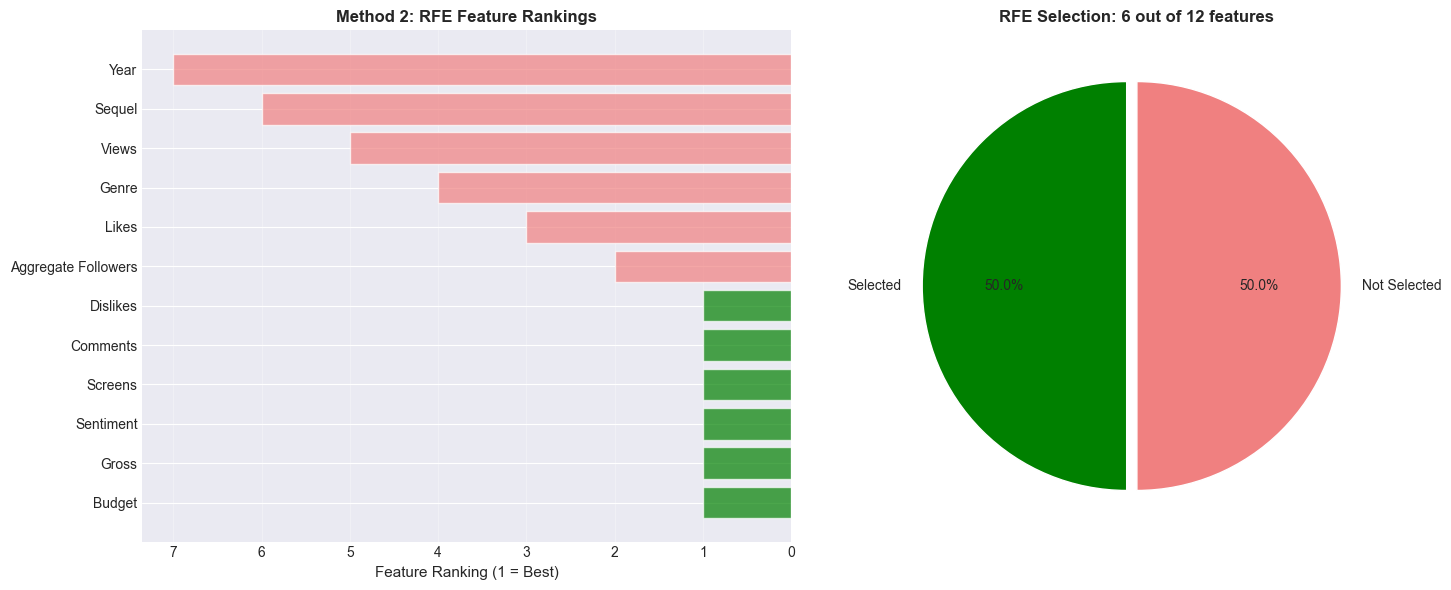


RFE selected 6 features using Random Forest


In [9]:
# Visualize RFE results
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Ranking plot
colors = ['green' if rank == 1 else 'lightcoral' for rank in feature_ranking['Ranking']]
axes[0].barh(feature_ranking['Feature'], feature_ranking['Ranking'], color=colors, alpha=0.7)
axes[0].set_xlabel('Feature Ranking (1 = Best)', fontsize=11)
axes[0].set_title('Method 2: RFE Feature Rankings', fontsize=12, fontweight='bold')
axes[0].invert_xaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Selected vs Not Selected
selection_counts = feature_ranking['Selected'].value_counts()
axes[1].pie(selection_counts.values, 
           labels=['Selected', 'Not Selected'],
           colors=['green', 'lightcoral'],
           autopct='%1.1f%%',
           startangle=90,
           explode=(0.05, 0))
axes[1].set_title(f'RFE Selection: {k} out of {len(X.columns)} features', 
                 fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nRFE selected {k} features using Random Forest")

---
## 5. Method 3: Tree-Based Feature Importance

In [11]:
print("METHOD 3: TREE-BASED FEATURE IMPORTANCE\n")

# Train Random Forest to get feature importances
print(f"\nTraining Random Forest to compute feature importances...")

rf_model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1, max_depth=10)
rf_model.fit(X, y)

# Get feature importances
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTraining Complete!")
print("\nFeature Importances:")
print("-" * 50)
for idx, row in importances.iterrows():
    print(f"{importances.index.get_loc(idx)+1:2d}. {row['Feature']:25s}: {row['Importance']:.4f}")

# Select top k features
selected_features_tree = importances.head(k)['Feature'].tolist()

print(f"\nSELECTED FEATURES (Tree-based - Top {k}):")
for idx, feature in enumerate(selected_features_tree, 1):
    importance_score = importances[importances['Feature'] == feature]['Importance'].values[0]
    print(f"{idx}. {feature} (importance: {importance_score:.4f})")

# Store results
method3_results = {
    'method': 'Tree-Based Importance',
    'selected_features': selected_features_tree,
    'n_features': k,
    'scores': dict(zip(importances['Feature'], importances['Importance']))
}

METHOD 3: TREE-BASED FEATURE IMPORTANCE


Training Random Forest to compute feature importances...

Training Complete!

Feature Importances:
--------------------------------------------------
 1. Gross                    : 0.1881
 2. Sentiment                : 0.1207
 3. Dislikes                 : 0.1150
 4. Budget                   : 0.1128
 5. Screens                  : 0.0911
 6. Comments                 : 0.0859
 7. Genre                    : 0.0789
 8. Aggregate Followers      : 0.0743
 9. Likes                    : 0.0647
10. Views                    : 0.0427
11. Sequel                   : 0.0157
12. Year                     : 0.0101

SELECTED FEATURES (Tree-based - Top 6):
1. Gross (importance: 0.1881)
2. Sentiment (importance: 0.1207)
3. Dislikes (importance: 0.1150)
4. Budget (importance: 0.1128)
5. Screens (importance: 0.0911)
6. Comments (importance: 0.0859)


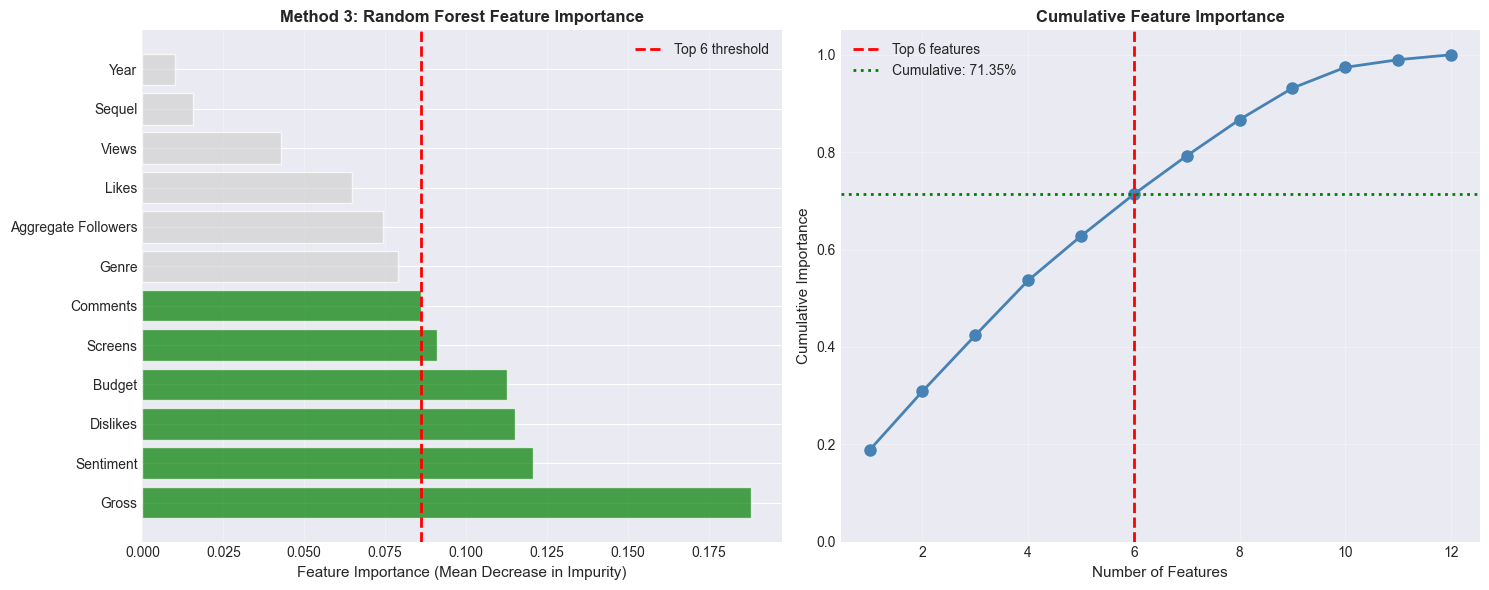


Top 6 features explain 71.35% of total importance


In [12]:
# Visualize feature importances
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot of all importances
colors = ['green' if f in selected_features_tree else 'lightgray' for f in importances['Feature']]
axes[0].barh(importances['Feature'], importances['Importance'], color=colors, alpha=0.7)
axes[0].set_xlabel('Feature Importance (Mean Decrease in Impurity)', fontsize=11)
axes[0].set_title('Method 3: Random Forest Feature Importance', fontsize=12, fontweight='bold')
axes[0].axvline(x=importances['Importance'].iloc[k-1], color='red', linestyle='--', 
               linewidth=2, label=f'Top {k} threshold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='x')

# Cumulative importance
cumulative_importance = importances['Importance'].cumsum()
axes[1].plot(range(1, len(cumulative_importance)+1), cumulative_importance, 
            marker='o', linewidth=2, markersize=8, color='steelblue')
axes[1].axvline(x=k, color='red', linestyle='--', linewidth=2, label=f'Top {k} features')
axes[1].axhline(y=cumulative_importance.iloc[k-1], color='green', linestyle=':', 
               linewidth=2, label=f'Cumulative: {cumulative_importance.iloc[k-1]:.2%}')
axes[1].set_xlabel('Number of Features', fontsize=11)
axes[1].set_ylabel('Cumulative Importance', fontsize=11)
axes[1].set_title('Cumulative Feature Importance', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

print(f"\nTop {k} features explain {cumulative_importance.iloc[k-1]:.2%} of total importance")

---
## 6. Compare Results from All Three Methods

In [14]:
print("COMPARISON OF ALL THREE METHODS\n")

# Create comparison table
all_features = X.columns.tolist()
comparison_data = []

for feature in all_features:
    comparison_data.append({
        'Feature': feature,
        'Method 1 (Corr)': '/' if feature in selected_features_corr else '',
        'Method 2 (RFE)': '/' if feature in selected_features_rfe else '',
        'Method 3 (Tree)': '/' if feature in selected_features_tree else '',
        'Selected Count': sum([
            feature in selected_features_corr,
            feature in selected_features_rfe,
            feature in selected_features_tree
        ])
    })

comparison_df = pd.DataFrame(comparison_data).sort_values('Selected Count', ascending=False)

print("\nFeature Selection Summary:")
print("-" * 80)
print(comparison_df.to_string(index=False))

# Find consensus features (selected by all 3 methods)
consensus_features = comparison_df[comparison_df['Selected Count'] == 3]['Feature'].tolist()
majority_features = comparison_df[comparison_df['Selected Count'] >= 2]['Feature'].tolist()

print("CONSENSUS ANALYSIS\n")

print(f"\n Features selected by ALL 3 methods ({len(consensus_features)}):")
for idx, feature in enumerate(consensus_features, 1):
    print(f"  {idx}. {feature}")

print(f"\n Features selected by AT LEAST 2 methods ({len(majority_features)}):")
for idx, feature in enumerate(majority_features, 1):
    count = comparison_df[comparison_df['Feature'] == feature]['Selected Count'].values[0]
    print(f"  {idx}. {feature} (selected by {count}/3 methods)")

print(f"\n Features selected by ONLY 1 method:")
single_method_features = comparison_df[comparison_df['Selected Count'] == 1]['Feature'].tolist()
for idx, feature in enumerate(single_method_features, 1):
    methods = []
    if feature in selected_features_corr:
        methods.append('Correlation')
    if feature in selected_features_rfe:
        methods.append('RFE')
    if feature in selected_features_tree:
        methods.append('Tree-based')
    print(f"  {idx}. {feature} ({', '.join(methods)})")

COMPARISON OF ALL THREE METHODS


Feature Selection Summary:
--------------------------------------------------------------------------------
            Feature Method 1 (Corr) Method 2 (RFE) Method 3 (Tree)  Selected Count
             Budget               /              /               /               3
              Gross               /              /               /               3
           Dislikes               /              /               /               3
          Sentiment               /              /               /               3
           Comments                              /               /               2
            Screens                              /               /               2
             Sequel               /                                              1
              Genre               /                                              1
               Year                                                              0
              Views         

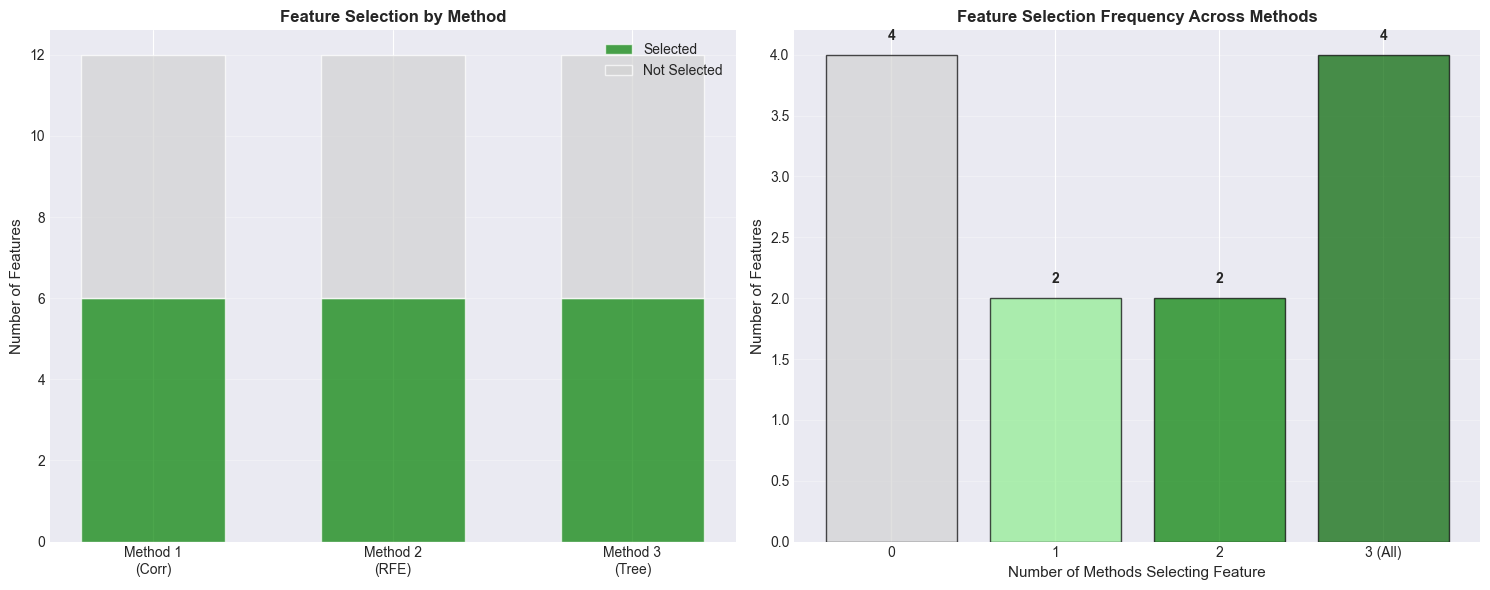

In [15]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Stacked bar chart showing selection by each method
methods = ['Method 1\n(Corr)', 'Method 2\n(RFE)', 'Method 3\n(Tree)']
selected_counts = [
    len(selected_features_corr),
    len(selected_features_rfe),
    len(selected_features_tree)
]
not_selected = [len(X.columns) - count for count in selected_counts]

x = np.arange(len(methods))
width = 0.6

axes[0].bar(x, selected_counts, width, label='Selected', color='green', alpha=0.7)
axes[0].bar(x, not_selected, width, bottom=selected_counts, label='Not Selected', 
           color='lightgray', alpha=0.7)
axes[0].set_ylabel('Number of Features', fontsize=11)
axes[0].set_title('Feature Selection by Method', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(methods)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Selection frequency
selection_freq = comparison_df['Selected Count'].value_counts().sort_index(ascending=False)
colors_freq = ['darkgreen', 'green', 'lightgreen', 'lightgray']
axes[1].bar(selection_freq.index, selection_freq.values, 
           color=colors_freq[:len(selection_freq)], alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Number of Methods Selecting Feature', fontsize=11)
axes[1].set_ylabel('Number of Features', fontsize=11)
axes[1].set_title('Feature Selection Frequency Across Methods', fontsize=12, fontweight='bold')
axes[1].set_xticks([0, 1, 2, 3])
axes[1].set_xticklabels(['0', '1', '2', '3 (All)'])
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, v in enumerate(selection_freq.values):
    axes[1].text(selection_freq.index[i], v + 0.1, str(v), 
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

---
## 7. Recommended Feature Sets

In [19]:
print("RECOMMENDED FEATURE SETS FOR CLASSIFICATION\n")

# Majority features (at least 2 methods)
print("\nMAJORITY FEATURES (Balanced)")
print(f"Features: {len(majority_features)}")
print(f"List: {majority_features}")


RECOMMENDED FEATURE SETS FOR CLASSIFICATION


MAJORITY FEATURES (Balanced)
Features: 6
List: ['Budget', 'Gross', 'Dislikes', 'Sentiment', 'Comments', 'Screens']


---
## 8. Export Results

In [20]:
print("EXPORTING ATTRIBUTE SELECTION RESULTS\n")

# Export 1: Comparison table
comparison_df.to_csv('step3_feature_selection_comparison.csv', index=False)
print("\nSaved: step3_feature_selection_comparison.csv")

# Export 2: Detailed results for each method
detailed_results = {
    'Method_1_Correlation': {
        'selected_features': selected_features_corr,
        'scores': {feat: float(correlations[feat]) for feat in selected_features_corr}
    },
    'Method_2_RFE': {
        'selected_features': selected_features_rfe,
        'rankings': {feat: int(method2_results['rankings'][feat]) for feat in X.columns}
    },
    'Method_3_Tree_Based': {
        'selected_features': selected_features_tree,
        'importances': {feat: float(method3_results['scores'][feat]) for feat in X.columns}
    }
}

import json
with open('step3_feature_selection_results.json', 'w') as f:
    json.dump(detailed_results, f, indent=4)
print("Saved: step3_feature_selection_results.json")

# Majority features
df_majority = df[['Movie'] + majority_features + ['Ratings']]
df_majority.to_csv('step3_data_majority_features.csv', index=False)
print("Saved: step3_data_majority_features.csv")

EXPORTING ATTRIBUTE SELECTION RESULTS


Saved: step3_feature_selection_comparison.csv
Saved: step3_feature_selection_results.json
Saved: step3_data_majority_features.csv
